# CS6700: Reinforcement Learning Programming Assignment 3


In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import random
import gymnasium as gym
import glob
import io
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
from IPython.display import HTML, clear_output
from tqdm import tqdm
import optuna
from collections import deque, namedtuple

In [2]:
env = gym.make('Taxi-v3', render_mode="ansi")
state = env.reset()[0]
print("Number of states:", env.observation_space.n)

action = ["south", "north", "east", "west", "pick", "drop"]
print("Number of actions that an agent can take:", env.action_space.n)

rnd_action = env.action_space.sample()
print("Action taken:", action[rnd_action])

next_state, reward, terminated, truncated, info = env.step(rnd_action)
done = terminated or truncated

print("Transition probability:", info['prob'])
print("Next state:", next_state)
print("Reward recieved:", reward)
print("Terminal state:", done)

print("Decoded state:", list(env.unwrapped.decode(state)))
print(env.render())

Number of states: 500
Number of actions that an agent can take: 6
Action taken: west
Transition probability: 1.0
Next state: 428
Reward recieved: -1
Terminal state: False
Decoded state: [4, 1, 2, 0]
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)



Define $\epsilon$-greedy action selection

In [3]:
def choose_action(q_values, epsilon=0.01):
  if q_values.any() and np.random.random() > epsilon:
    return np.argmax(q_values)
  choice = np.random.randint(0, q_values.shape[0]-1)
  return choice

All primitive actions can be defined as one-step options by configuring option policy to the particular action on all states, and setting $\beta = 1$ for all states. 

We use a collections.namedtuple structure to store the policy (a callable function) and termination set of states for our option. In this assignment the initation set is considered to be the entire state-space for all options.

In [4]:
Option = namedtuple('Option', ['policy', 'terminate'])

# One-step options
grid = [(i, j) for i in range(5) for j in range(5)]
decode = lambda state: tuple(env.unwrapped.decode(state))[:2]

S = Option(lambda state: 0, grid)
N = Option(lambda state: 1, grid)
E = Option(lambda state: 2, grid)
W = Option(lambda state: 3, grid)
P = Option(lambda state: 4, grid)
D = Option(lambda state: 5, grid)

We first define the IOQL algorithm below.

In [5]:
def ioq_learning(options, episodes=10000, print_freq=2000, epsilon=0.01, alpha=0.1, gamma=0.9, ioql = True, seed=1, track=True):

    np.random.seed(seed)

    Q = np.zeros((env.observation_space.n, len(options)))

    episode_rewards = np.zeros(episodes)
    scores_window = deque(maxlen=100)
    avg_rewards = []

    for ep in range(episodes):
        tot_reward = 0
        state, info = env.reset()
        done = False

        while not done:
            option_no = choose_action(Q[state], epsilon)
            option = options[option_no]

            option_done = False
            option_reward = 0
            option_init = int(state)
            discount = 1
            
            while not option_done:
                action = option.policy(state)
                state_next, reward, terminated, truncated, _ = env.step(action)

                if ioql:
                    # Update all options (including one-step) with consistent policy action at state
                    for c_option_no in range(len(options)):
                        c_option = options[c_option_no]
                        # Check if consistent
                        if c_option.policy(state) == action:
                            # Update state, action pairs' value
                            if decode(state_next) in c_option.terminate:
                                Q[state, c_option_no] = (1 - alpha) * Q[state, c_option_no] + alpha * (reward + gamma * np.max(Q[state_next]))
                            else:
                                Q[state, c_option_no] = (1 - alpha) * Q[state, c_option_no] + alpha * (reward + gamma * Q[state_next, c_option_no])

                done = terminated or truncated
                option_done = decode(state_next) in option.terminate

                option_reward += discount * reward
                discount *= gamma
                tot_reward += reward
                state = state_next

            Q[option_init, option_no] = (1 - alpha) * Q[option_init, option_no] + alpha * (option_reward + discount * np.max(Q[state_next]))

        episode_rewards[ep] = tot_reward
        scores_window.append(tot_reward)
        
        if track:
            last100 = np.mean(np.mean(scores_window))
            print("\rEpisode %d: Reward: %f"%(ep+1, last100), end="")
            avg_rewards.append(last100)

            if (ep+1)%print_freq == 0:
                print("\rEpisode %d: Reward: %f"%(ep+1, last100))

    return Q, episode_rewards, avg_rewards

SMDP Learning is IOQL minus the updates to all option policies (including the actions (primitive options) and current option) consistent with the current options' policy.

In [6]:
def smdp_learning(options, episodes=10000, print_freq=2000, epsilon=0.01, alpha=0.1, gamma=0.9):
    return ioq_learning(options, episodes, print_freq, epsilon, alpha, gamma, ioql = False)

SMDP Learning with all actions taking unit time is just Q-Learning. We perform Vanilla Q-Learning using our defined one-step options and obtain the Q-Table.

We then obtain policies for the option "Goto X" from the learnt Q Function in the following way:
- Fix passenger location to X, and the destination to any i $\ne$ X (we use $(X+1) \mod 4$). Only 25 states, of the form $(i, j, X, (X+1) \mod 4)$ satisfy the constraint.
- Taking a cross-section of the Q-Table on this set of states, reshaping result to 5x5x6, and argmax (or $\epsilon$-greedy) along the 3rd axis gives the policy for this option.

In [7]:
# Perform Ordinary Q-Learning
# Equivalent to SMDP-Learning on One-step Options
Q, _, _ = smdp_learning([S, N, E, W, P, D], episodes=10000, print_freq=2000)

# # Get policy for the option: Goto X from the Q function
# We fix passenger location to X, and the destination to (X+1)%4
# All states corresponding to the above will be a 5x5x6 grid
# e-greedy/argmax over this Q-grid gives a policy for Goto X

policy_grids = []
for k in range(4):
    policy_grid = Q[[env.unwrapped.encode(i, j, k, (k+1)%4) for i in range(5) for j in range(5)]].reshape(5, 5, 6).argmax(axis=2)
    policy_grids.append(policy_grid)


Episode 2000: Reward: 7.21000000
Episode 4000: Reward: 8.400000
Episode 6000: Reward: 7.630000
Episode 8000: Reward: 6.810000
Episode 10000: Reward: 7.790000


Visualization of the Q-Function of obtained policies

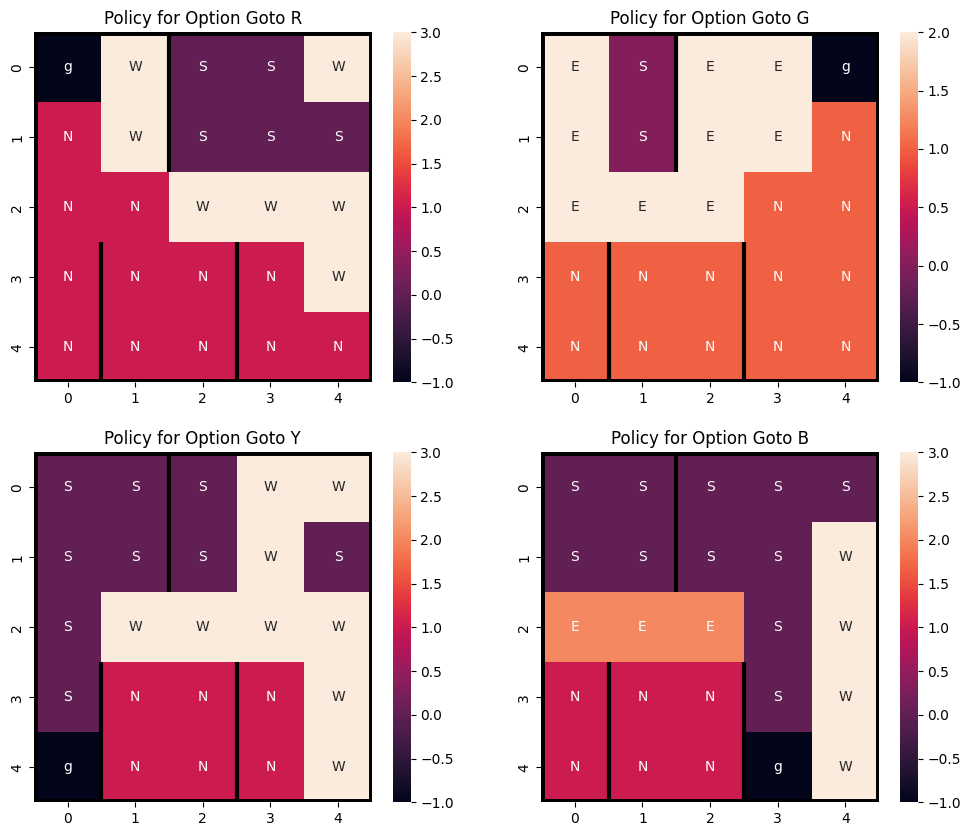

In [8]:
option_terminations = [(0, 0), (0, 4), (4, 0), (4, 3)]

action_names = ["S", "N", "E", "W", "P", "D"]

def add_border(hmap):
    hmap.add_patch(Rectangle((2, 0), 0, 2, lw=3, edgecolor='black'))
    hmap.add_patch(Rectangle((1, 3), 0, 2, lw=3, edgecolor='black'))
    hmap.add_patch(Rectangle((3, 3), 0, 2, lw=3, edgecolor='black'))
    hmap.add_patch(Rectangle((0, 0), 5, 5, lw=5, edgecolor='black', fill=False))

plt.figure(figsize=(12, 10))
for i in range(4): 
    plt.subplot(2, 2, i+1)
    policy_grid = np.array(policy_grids[i])
    labels = np.vectorize(lambda i: action_names[i])(policy_grid)
    labels[option_terminations[i]], policy_grid[option_terminations[i]] = 'goal', -1
    plt.title('Policy for Option Goto ' + 'RGYB'[i])
    add_border(sns.heatmap(policy_grid, annot=labels, fmt=''))

Define Options using the obtained policies

In [9]:
macro_options = []
option_policy_generator = lambda grid: (lambda state: (grid[decode(state)]))

for policy_grid, term_state in zip(policy_grids, option_terminations):
    policy_func = option_policy_generator(policy_grid)
    option = Option(policy_func, [term_state])
    macro_options.append(option)

R, G, Y, B = macro_options

Define Mutually Exclusive Options

In [10]:
# Mutually exclusive policies: SOUTH, NORTH, EAST, WEST
SOUTH = Option(lambda state: 0, [(4, i) for i in range(5)])
NORTH = Option(lambda state: 1, [(0, i) for i in range(5)])

EAST = Option(lambda state: 2, [(i, 4) for i in range(5)] + [(0, 1), (1, 1), (3, 0), (4, 0), (3, 2), (4, 2)])
WEST = Option(lambda state: 3, [(i, 0) for i in range(5)] + [(0, 2), (1, 2), (3, 1), (4, 1), (3, 3), (4, 3)])

Perform Hyperparameter Tuning for SMDP, IOQL with given goto X options, and also with mutually exclusive options.

In [11]:
# def objective(trial, func):

#     alpha = trial.suggest_float("alpha", 0, 1)
#     epsilon = trial.suggest_float("epsilon", 1e-5, 0.1)

#     episode_rewards = func([S, N, E, W, P, D, R, G, Y, B], episodes=10000, print_freq=100000, alpha=alpha, epsilon=epsilon, track=False)[1]
#     regret = -1 * episode_rewards

#     return regret.mean()

# for name, func in [('SMDP', smdp_learning), ('IOQL', ioq_learning)]:

#     study = optuna.create_study(
#             study_name=name,
#             direction='minimize',
#             load_if_exists=True,
#             storage=f'sqlite:///hpt_results.db',
#         )
    
#     study.optimize((lambda trial: objective(trial, func)), n_trials=50)

# def objective(trial, func):

#     alpha = trial.suggest_float("alpha", 0, 1)
#     epsilon = trial.suggest_float("epsilon", 1e-5, 0.1)

#     episode_rewards = func([S, N, E, W, P, D, SOUTH, NORTH, EAST, WEST], episodes=10000, print_freq=100000, alpha=alpha, epsilon=epsilon, track=False)[1]
#     regret = -1 * episode_rewards

#     return regret.mean()

# for name, func in [('SMDP Exclusive', smdp_learning), ('IOQL Exclusive', ioq_learning)]:

#     study = optuna.create_study(
#             study_name=name,
#             direction='minimize',
#             load_if_exists=True,
#             storage=f'sqlite:///hpt_results.db',
#         )
    
#     study.optimize((lambda trial: objective(trial, func)), n_trials=50)

In [12]:
summaries = optuna.study.get_all_study_summaries(storage="sqlite:///hpt_results.db")

In [13]:
for summary in summaries:
    print(f'{summary.study_name} results:\n\nNumber of trials = {summary.n_trials}')
    print(f'Best Trial Hyperparameters:\n\talpha = {summary.best_trial.params['alpha']:.7f}\n\tepsilon = {summary.best_trial.params['epsilon']:.7f}')
    print('-'*20)

IOQL results:

Number of trials = 50
Best Trial Hyperparameters:
	alpha = 0.5777660
	epsilon = 0.0046396
--------------------
SMDP results:

Number of trials = 50
Best Trial Hyperparameters:
	alpha = 0.7365430
	epsilon = 0.0014736
--------------------
IOQL Exclusive results:

Number of trials = 50
Best Trial Hyperparameters:
	alpha = 0.8030125
	epsilon = 0.0005293
--------------------
SMDP Exclusive results:

Number of trials = 50
Best Trial Hyperparameters:
	alpha = 0.8028770
	epsilon = 0.0002563
--------------------


In [14]:
studies = {'SMDP':[], 'IOQL':[], 'SMDP Exclusive':[], 'IOQL Exclusive':[]}

for name in studies:
    study = optuna.create_study(
            study_name=name,
            direction='minimize',
            load_if_exists=True,
            storage=f'sqlite:///hpt_results.db',
        )
    
    print(name, study.best_params)
    alpha, epsilon = [i[1] for i in list(study.best_params.items())]

    if 'Exclusive' in name:
        opts = [S, N, E, W, P, D, SOUTH, NORTH, EAST, WEST]
    else:
        opts = [S, N, E, W, P, D, R, G, Y, B]
    
    if 'SMDP' in name:
        studies[name] = smdp_learning(opts, episodes=10000, print_freq=100000, alpha=alpha, epsilon=epsilon)
        # studies[name] = smdp_learning(opts, episodes=10000, print_freq=100000)
    else:
        studies[name] = ioq_learning(opts, episodes=10000, print_freq=100000, alpha=alpha, epsilon=epsilon)
        # studies[name] = ioq_learning(opts, episodes=10000, print_freq=100000)

[I 2024-04-20 15:36:36,101] Using an existing study with name 'SMDP' instead of creating a new one.


SMDP {'alpha': 0.7365429786787754, 'epsilon': 0.001473601882636585}
Episode 9930: Reward: 7.17000000

[I 2024-04-20 15:36:41,142] Using an existing study with name 'IOQL' instead of creating a new one.


Episode 10000: Reward: 7.100000IOQL {'alpha': 0.5777659987400294, 'epsilon': 0.004639622624027949}
Episode 10000: Reward: 7.7700000

[I 2024-04-20 15:36:50,160] Using an existing study with name 'SMDP Exclusive' instead of creating a new one.


SMDP Exclusive {'alpha': 0.8028770085043976, 'epsilon': 0.0002562669109174619}
Episode 9863: Reward: 6.60000000

[I 2024-04-20 15:36:55,958] Using an existing study with name 'IOQL Exclusive' instead of creating a new one.


Episode 10000: Reward: 6.080000IOQL Exclusive {'alpha': 0.8030125486968736, 'epsilon': 0.0005293254386158884}
Episode 10000: Reward: 7.7700000

SMDP policys:

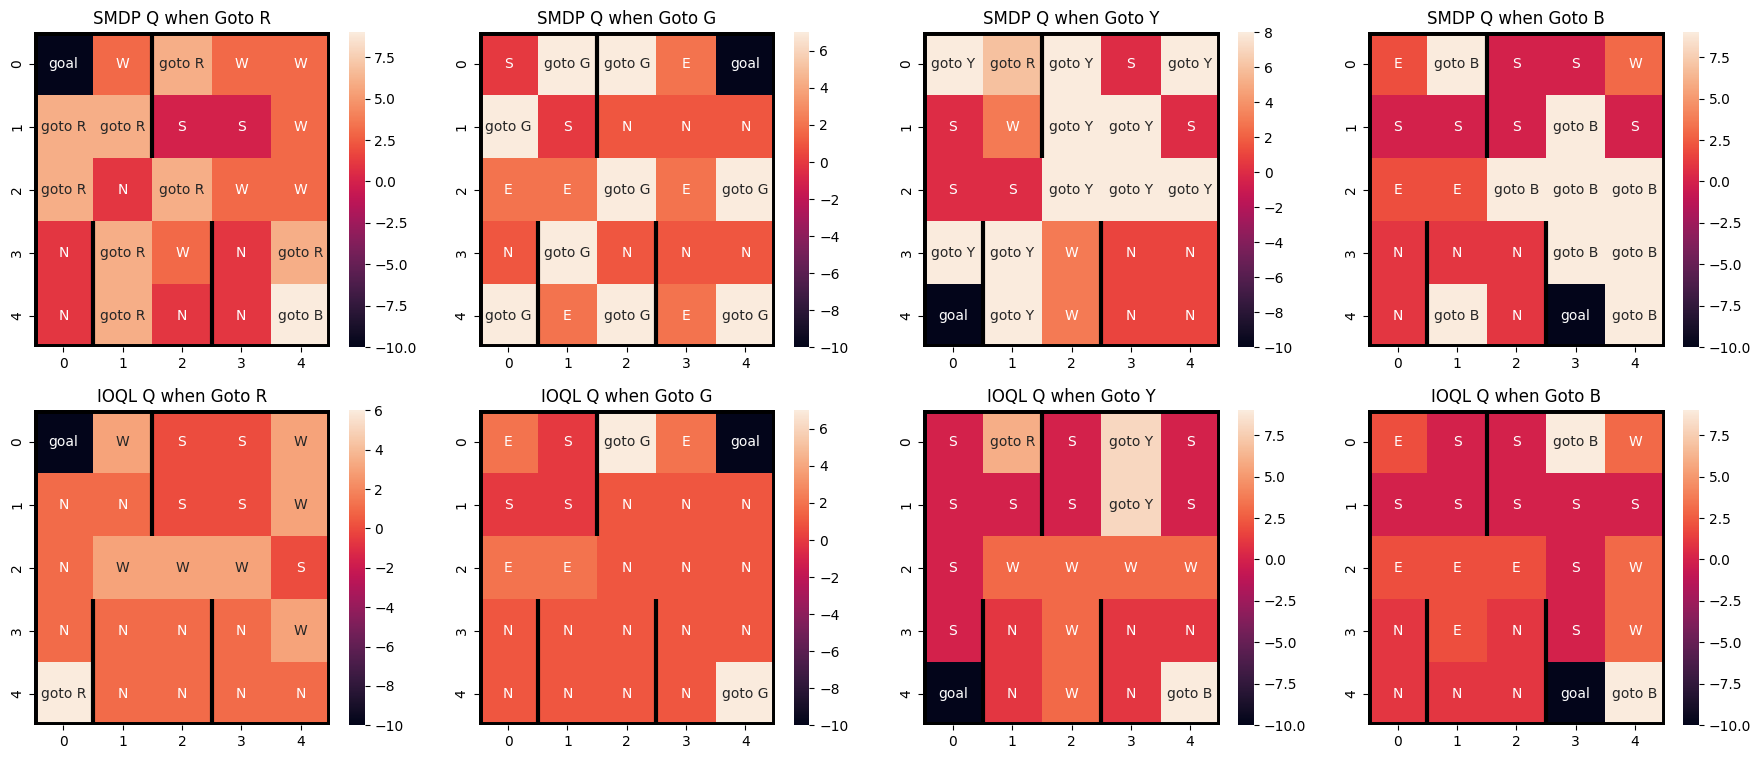

In [30]:
action_names = ["S", "N", "E", "W", "P", "D", 'goto R', 'goto G', 'goto Y', 'goto B']

j = 0
plt.figure(figsize=(22, 9))

for study_name in ['SMDP', 'IOQL']:

    grids = []
    for k in range(4):
        grid = studies[study_name][0][[env.unwrapped.encode(i, j, k, (k+1)%4) for i in range(5) for j in range(5)]].reshape(5, 5, studies[study_name][0].shape[1]).argmax(axis=2)
        grids.append(grid)

    for i in range(4): 
        plt.subplot(2, 4, i+1+4*j)
        grid = np.array(grids[i])
        labels = np.vectorize(lambda i: action_names[i])(grid)
        labels[option_terminations[i]], grid[option_terminations[i]] = 'goal', -10
        plt.title(f'{study_name} Q when Goto ' + 'RGYB'[i])
        add_border(sns.heatmap(grid, annot=labels, fmt=''))
    
    j+=1

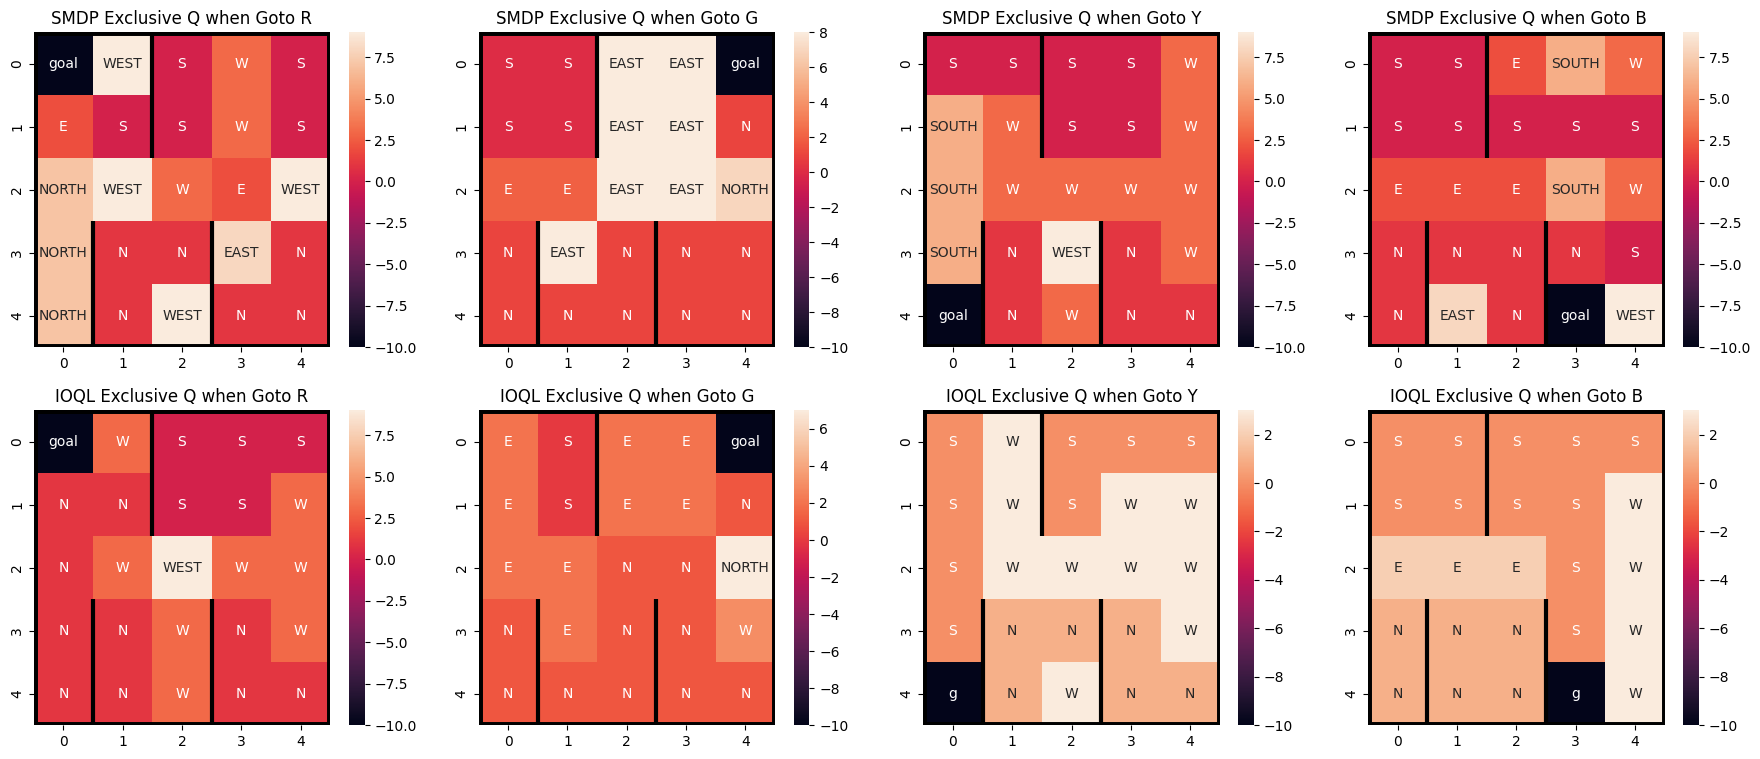

In [25]:
action_names = ["S", "N", "E", "W", "P", "D", 'SOUTH', 'NORTH', 'EAST', 'WEST']

j = 0
plt.figure(figsize=(22, 9))

for study_name in ['SMDP Exclusive', 'IOQL Exclusive']:

    grids = []
    for k in range(4):
        grid = studies[study_name][0][[env.unwrapped.encode(i, j, k, (k+1)%4) for i in range(5) for j in range(5)]].reshape(5, 5, studies[study_name][0].shape[1]).argmax(axis=2)
        grids.append(grid)

    for i in range(4): 
        plt.subplot(2, 4, i+1+4*j)
        grid = np.array(grids[i])
        labels = np.vectorize(lambda i: action_names[i])(grid)
        labels[option_terminations[i]], grid[option_terminations[i]] = 'goal', -10
        plt.title(f'{study_name} Q when Goto ' + 'RGYB'[i])
        add_border(sns.heatmap(grid, annot=labels, fmt=''))
    
    j+=1

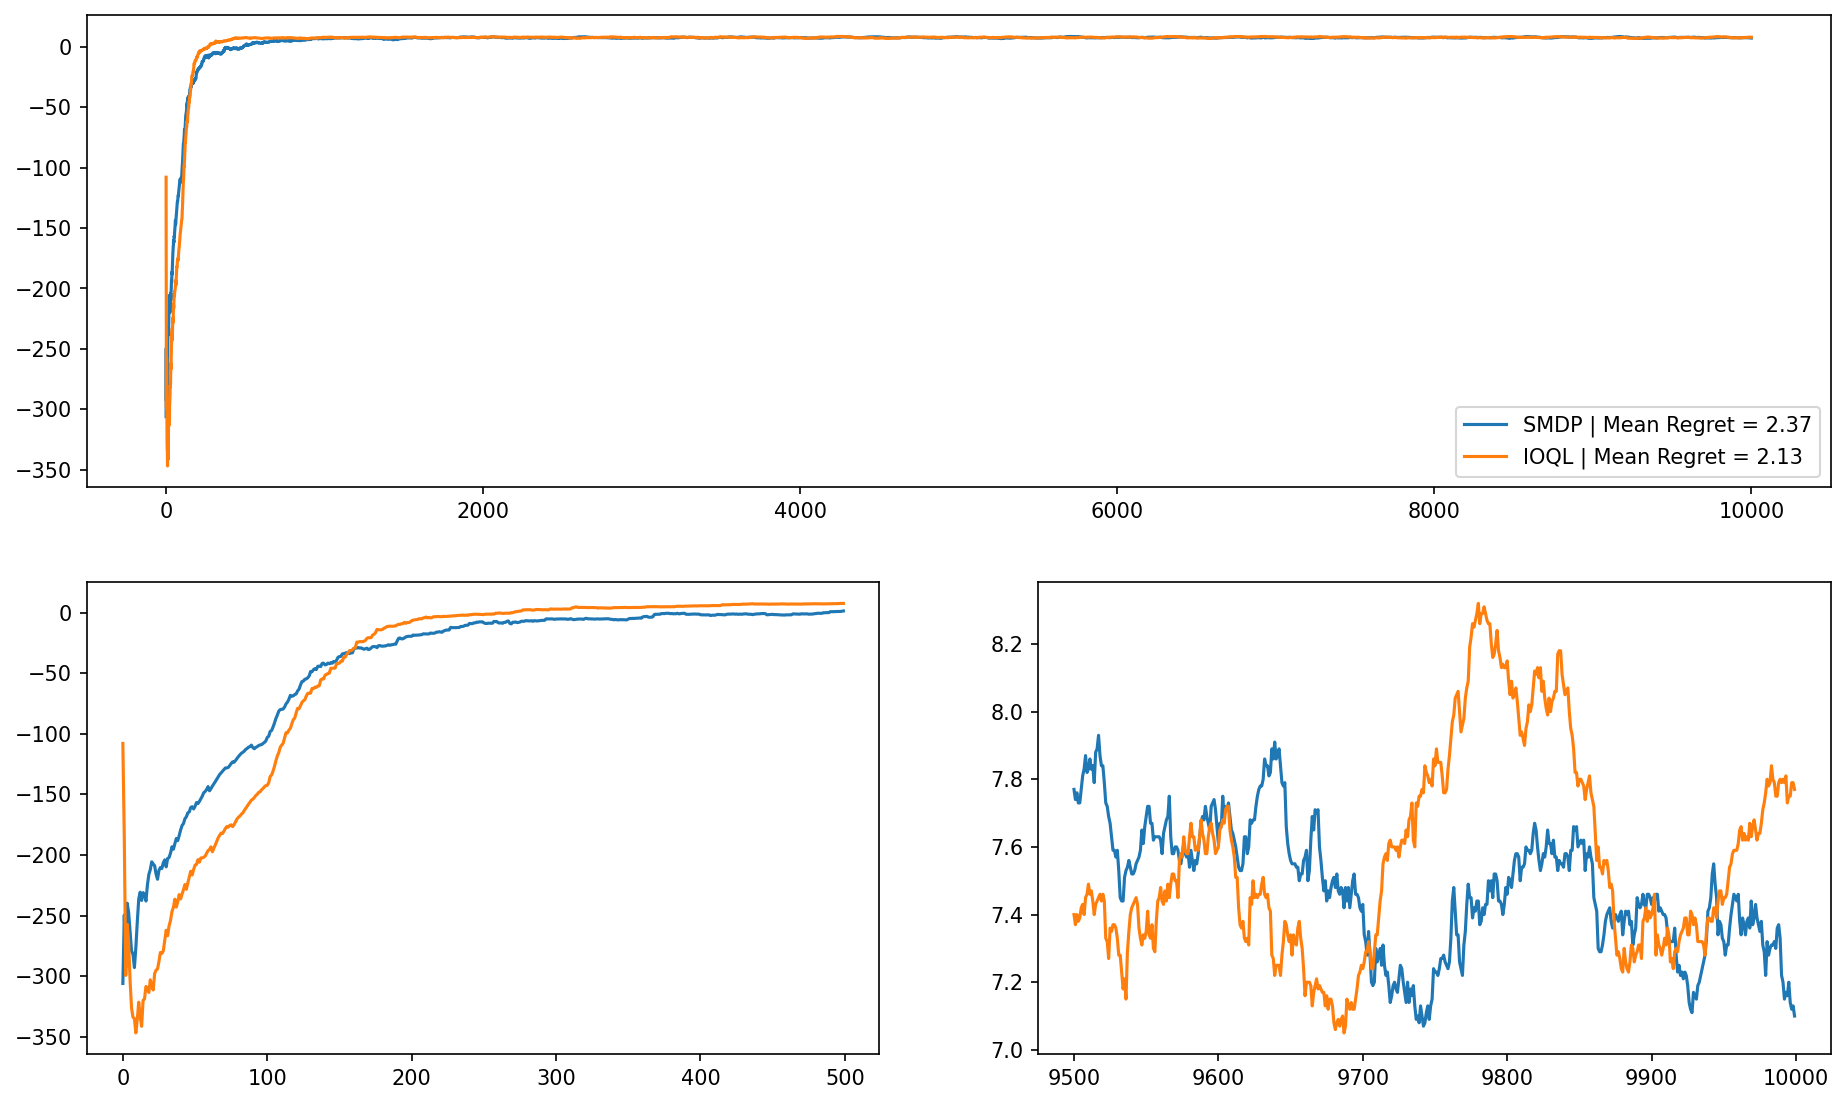

In [23]:
fig, ax = plt.subplot_mosaic("CC;AB", gridspec_kw={'height_ratios': [1, 1]}, figsize=(15, 9), dpi=150)
window_length = 500

for study_name in ['SMDP', 'IOQL']:
    ax['C'].plot(range(10000), studies[study_name][2], label=f'{study_name} | Mean Regret = {env.spec.reward_threshold-studies[study_name][1].mean():.2f}')
    ax['A'].plot(range(window_length), studies[study_name][2][:window_length])
    ax['B'].plot(range(10000-window_length, 10000), studies[study_name][2][-window_length:])

ax['C'].legend()

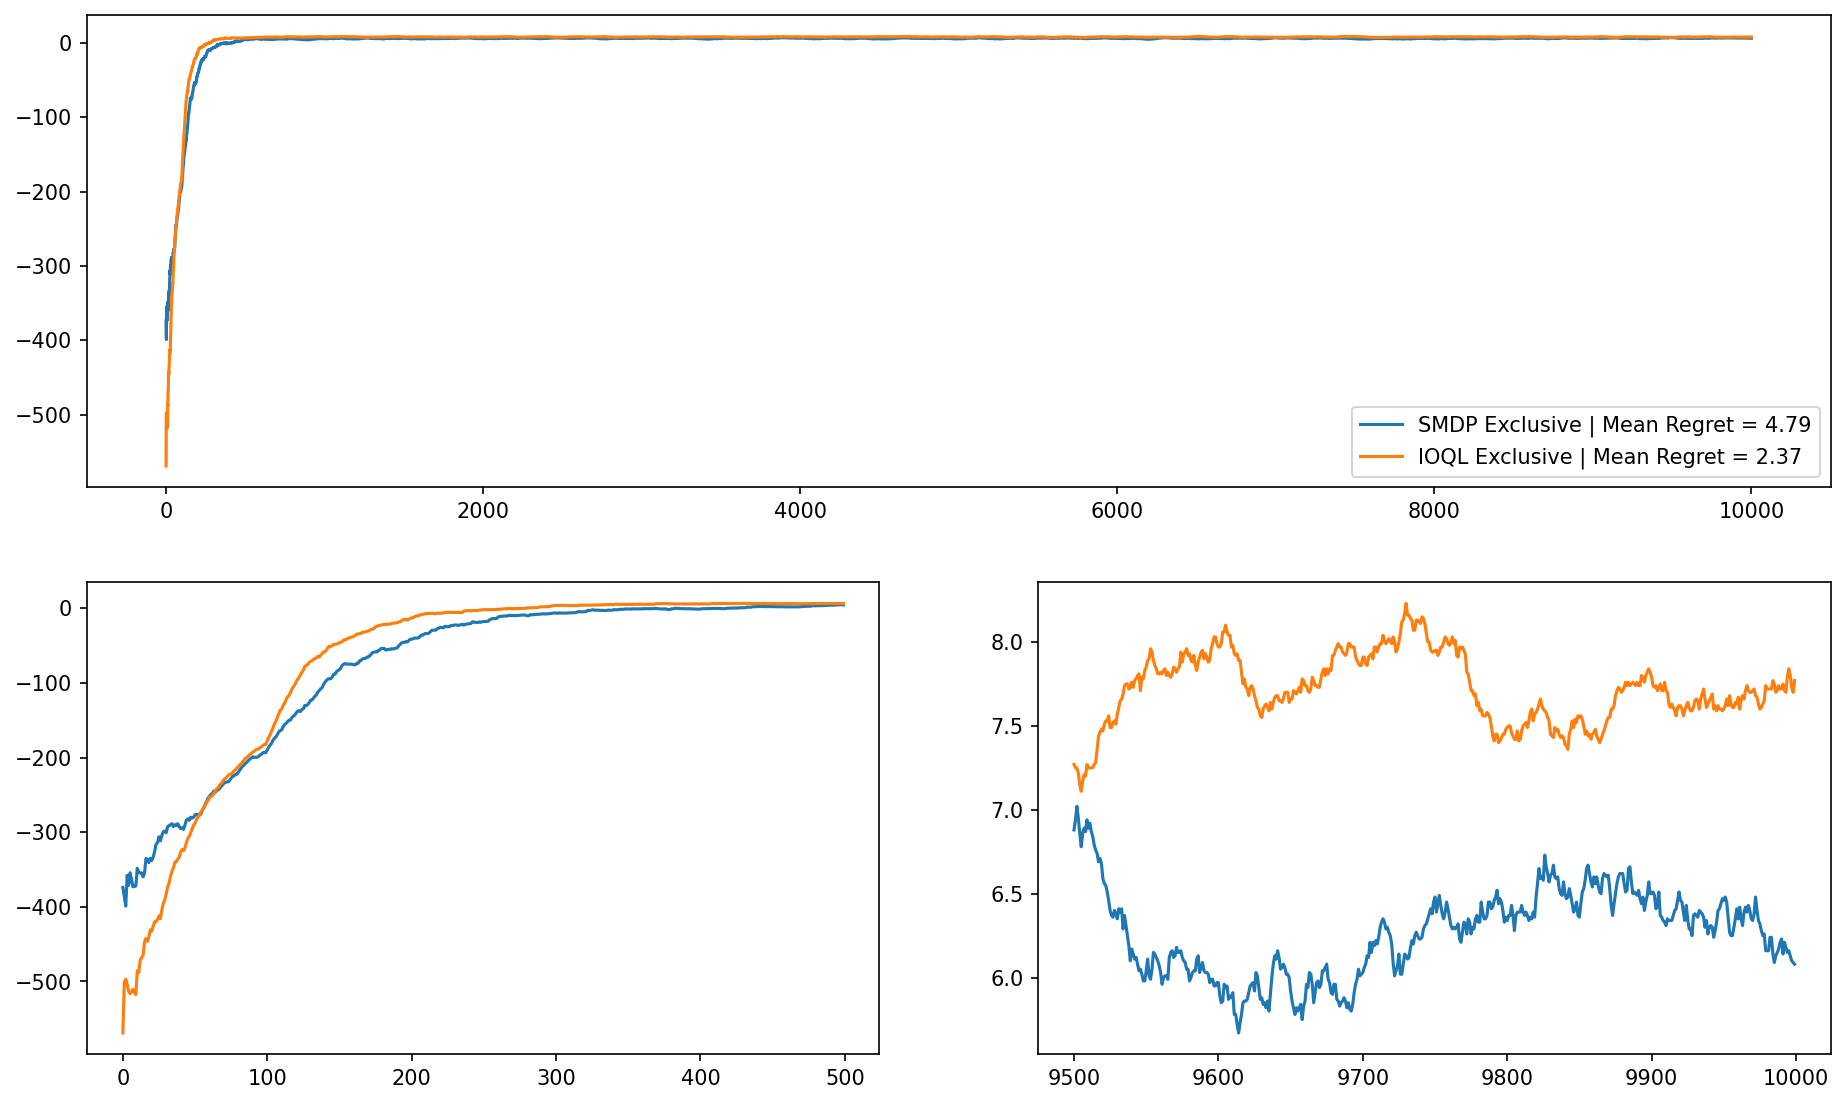

In [24]:
fig, ax = plt.subplot_mosaic("CC;AB", gridspec_kw={'height_ratios': [1, 1]}, figsize=(15, 9), dpi=150)

for study_name in ['SMDP Exclusive', 'IOQL Exclusive']:
    ax['C'].plot(range(10000), studies[study_name][2], label=f'{study_name} | Mean Regret = {env.spec.reward_threshold-studies[study_name][1].mean():.2f}')
    ax['A'].plot(range(window_length), studies[study_name][2][:window_length])
    ax['B'].plot(range(10000-window_length, 10000), studies[study_name][2][-window_length:])

ax['C'].legend()